In [30]:
# ===============================
# Imports and Setup
# ===============================

import numpy as np
import pandas as pd

from linearmodels.panel import PanelOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

print("Libraries imported successfully.")



Libraries imported successfully.


# Marketplace Pricing Elasticity Analysis (Panel Fixed Effects)

**Objective**  
Estimate price elasticity of demand using panel fixed-effects models and simulate revenue outcomes under alternative pricing scenarios in a marketplace setting.

**Methodology**  
- Synthetic panel data generation (products × time)  
- Product fixed effects using PanelOLS  
- Log–log demand specification  
- Revenue simulations under ± price changes  

**Relevance**  
This mirrors real-world pricing strategy problems faced by large-scale marketplaces, informing optimal price adjustments under demand elasticity.


In [31]:
# ==============================
# Synthetic Panel Data Generation
# ==============================

# Parameters
n_products = 100
n_periods = 24

# Create panel index
products = np.arange(n_products)
periods = np.arange(n_periods)

index = pd.MultiIndex.from_product(
    [products, periods],
    names=["product_id", "time"]
)

df = pd.DataFrame(index=index).reset_index()

# Product fixed effects (unobserved heterogeneity)
product_fe = np.random.normal(0, 0.5, n_products)
df["product_fe"] = df["product_id"].map(dict(zip(products, product_fe)))

# Time fixed effects (common shocks)
time_fe = np.random.normal(0, 0.3, n_periods)
df["time_fe"] = df["time"].map(dict(zip(periods, time_fe)))

# Simulated prices
df["price"] = np.exp(
    np.random.normal(loc=2.0, scale=0.2, size=len(df))
)

# True price elasticity
true_elasticity = -1.5

# Log demand
df["log_quantity"] = (
    5
    + true_elasticity * np.log(df["price"])
    + df["product_fe"]
    + df["time_fe"]
    + np.random.normal(scale=0.3, size=len(df))
)

# Quantity in levels
df["quantity"] = np.exp(df["log_quantity"])

df.head()


,product_id,time,product_fe,time_fe,price,log_quantity,quantity
0,0,0,0.248357,-0.424611,8.309267,1.924229,6.849867
1,0,1,0.248357,-0.126194,11.451161,1.609833,5.001977
2,0,2,0.248357,-0.102814,6.061109,2.568732,13.049267
3,0,3,0.248357,-0.240683,6.597828,2.359618,10.586911
4,0,4,0.248357,-0.048386,7.537799,2.787039,16.232883


In [32]:
# ================================
# Panel Fixed-Effects Estimation
# ================================

# Set panel index
panel_df = df.set_index(["product_id", "time"])

# Log-log specification
y = panel_df["log_quantity"]
X = panel_df[["price"]]
X = sm.add_constant(np.log(X))

# Fixed-effects model with product and time effects
fe_model = PanelOLS(
    y,
    X,
    entity_effects=True,
    time_effects=True
)

fe_results = fe_model.fit(
    cov_type="clustered",
    cluster_entity=True
)

fe_results.summary


Dep. Variable:,log_quantity,R-squared:,0.4858
Estimator:,PanelOLS,R-squared (Between):,-0.0307
No. Observations:,2400,R-squared (Within):,0.3094
Date:,"Mon, Dec 15 2025",R-squared (Overall):,0.1616
Time:,23:23:08,Log-likelihood,-460.29
Cov. Estimator:,Clustered,,
,,F-statistic:,2149.9
Entities:,100,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(1,2276)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,2372.7


In [33]:
# === Extract estimated elasticity robustly ===
params = fe_results.params

# Try to find the price coefficient by name, regardless of variations
price_key = None
for name in params.index:
    low = str(name).lower()
    if "price" in low:           # catches 'log_price', 'log(price)', 'price[T...]', etc.
        price_key = name
        break

# Fallback: first non-constant coefficient
if price_key is None:
    nonconst = [n for n in params.index if "const" not in str(n).lower() and "intercept" not in str(n).lower()]
    price_key = nonconst[0] if nonconst else params.index[0]

estimated_elasticity = float(params[price_key])

print(f"Using coefficient: {price_key}")
print(f"Estimated price elasticity of demand: {estimated_elasticity:.3f}")

if estimated_elasticity < -1:
    print("Demand is elastic in the observed range.")
else:
    print("Demand is inelastic in the observed range.")

Using coefficient: price
Estimated price elasticity of demand: -1.476
Demand is elastic in the observed range.


In [34]:
# Baseline revenue
df["revenue"] = df["price"] * df["quantity"]
baseline_revenue = df["revenue"].mean()

# Price change scenarios
price_changes = [0.01, 0.02, 0.05]
simulation_results = []

for pct in price_changes:
    new_price = df["price"] * (1 + pct)
    new_quantity = df["quantity"] * (1 + pct) ** estimated_elasticity
    new_revenue = (new_price * new_quantity).mean()

    simulation_results.append({
        "price_change_pct": f"{int(pct*100)}%",
        "avg_revenue": new_revenue,
        "pct_change_vs_baseline": (new_revenue / baseline_revenue - 1) * 100
    })

simulation_df = pd.DataFrame(simulation_results)
simulation_df


,price_change_pct,avg_revenue,pct_change_vs_baseline
0,1%,62.463903,-0.472715
1,2%,62.171529,-0.938570
2,5%,61.319217,-2.296608


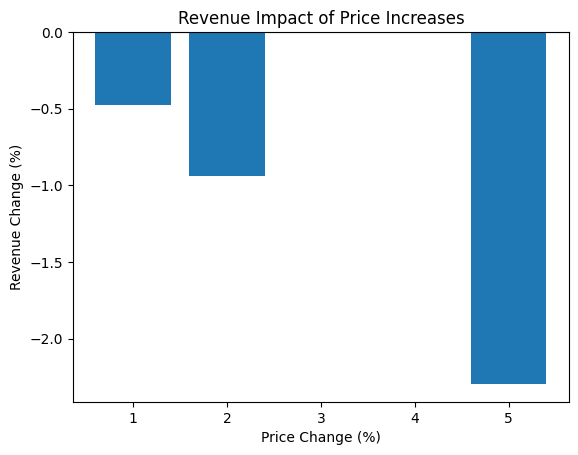

In [35]:
simulation_df["price_change_numeric"] = simulation_df["price_change_pct"].str.replace("%","").astype(int)

plt.figure()
plt.bar(
    simulation_df["price_change_numeric"],
    simulation_df["pct_change_vs_baseline"]
)
plt.axhline(0)
plt.xlabel("Price Change (%)")
plt.ylabel("Revenue Change (%)")
plt.title("Revenue Impact of Price Increases")
plt.show()

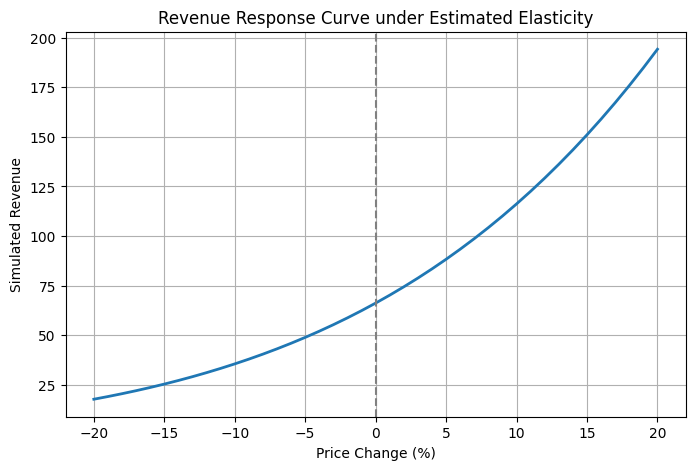

In [36]:
price_changes = np.linspace(-0.2, 0.2, 41)

base_price = df["price"].mean()
base_quantity = df["quantity"].mean()

elasticity = fe_results.params.iloc[0]

revenue_curve = []

for dp in price_changes:
    new_price = base_price * (1 + dp)
    new_quantity = base_quantity * (1 + dp) ** elasticity
    revenue_curve.append(new_price * new_quantity)

plt.figure(figsize=(8, 5))
plt.plot(price_changes * 100, revenue_curve, linewidth=2)
plt.axvline(0, linestyle="--", color="grey")
plt.xlabel("Price Change (%)")
plt.ylabel("Simulated Revenue")
plt.title("Revenue Response Curve under Estimated Elasticity")
plt.grid(True)
plt.show()
